In [1]:
#############################################导入包 ##################################################################################
####################################################################################################################################
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
from torch.utils import data
from torchvision import transforms

from PIL import Image, ImageOps
# import cv2
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"



ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.6 from "C:\software\anaconda\envs\pytorch\python.exe"
  * The NumPy version is: "1.19.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed: 找不到指定的模块。


In [2]:
####################################mnist数据集 做成小批量 放在一个迭代器中##########################################################################################
####################################################################################################################################
def load_data_mnist(batch_size, resize=None):  #@save
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="/media/atr/SSD2T/datasets/mnist/", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    print('训练集长度：',len(mnist_train))
    print('形状：',mnist_train[0][0].shape)

    return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=0),data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=0))


batch_size = 256
mnist_train_iter, mnist_test_iter = load_data_mnist(batch_size=batch_size)
# next(iter(mnist_train_iter)) ##查看数据

# ##查看图片
# batch_size = 18
# X, y = next(iter(load_data_mnist(batch_size=batch_size)[0]))
# d2l.show_images(X.reshape(18, 28, 28), 2, 9, titles=d2l.get_fashion_mnist_labels(y));

训练集长度： 60000
形状： torch.Size([1, 28, 28])


训练集长度： 60000
形状： torch.Size([1, 28, 28])


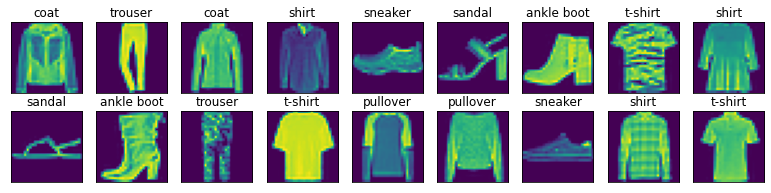

In [3]:
####################################Fashion_mnist数据集 做成小批量 放在一个迭代器中##########################################################################################
####################################################################################################################################
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    fashion_mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    fashion_mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    print('训练集长度：',len(fashion_mnist_train))
    print('形状：',fashion_mnist_train[0][0].shape)
    return (data.DataLoader(fashion_mnist_train, batch_size, shuffle=True,
                            num_workers=0),
            data.DataLoader(fashion_mnist_test, batch_size, shuffle=False,
                            num_workers=0))

# batch_size = 256
# fashion_mnist_train_iter, fashion_mnist_test_iter = load_data_fashion_mnist(batch_size=10)  ###返回随机一批训练集以及结果
# next(iter(fashion_mnist_train_iter))

##查看图片
batch_size = 18
X, y = next(iter(load_data_fashion_mnist(batch_size=batch_size)[0]))
d2l.show_images(X.reshape(18, 28, 28), 2, 9, titles=d2l.get_fashion_mnist_labels(y));

In [4]:
#############################################设置网络并且 查看每一层的情况##########################################################################################
################################################################################################################################################################################
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5,padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


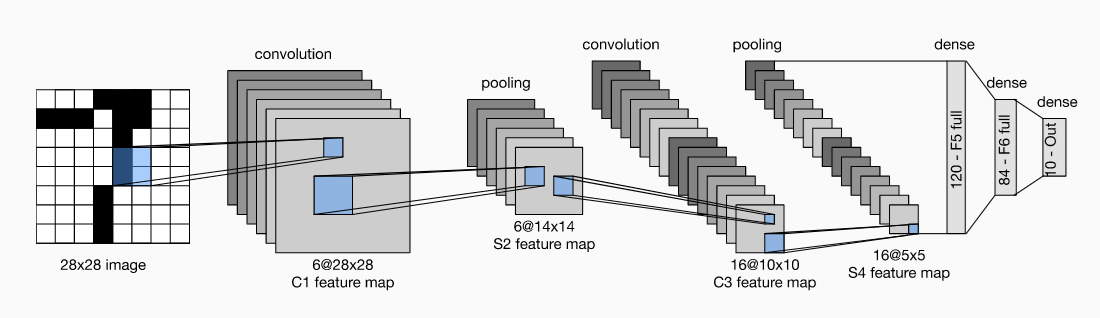
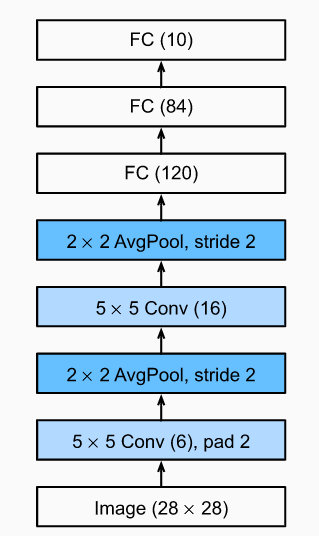

In [7]:
###############################################初始化模型#######################################################################################################################################
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)  
        
net.apply(init_weights)
print('初始化完成')


初始化完成


In [6]:
###############################################查看是否有GPU并且选择#############################################################################
print(torch.cuda.is_available())
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
###gpu 或者cup 训练
#device = torch.device( "cpu")   ###切换到使用cpu训练
print('在', device,'上训练')
net.to(device)

True
在 cuda:1 上训练


Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
#############################################设置训练函数以及准确率函数#########################################################################################################################################################################################
####################################################################################################################################
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]



def train(net, train_iter, test_iter, num_epochs, lr, device):
##############################################设置损失 优化############################################################################################
####################################################################################################################################
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    
    #device = torch.device( "cpu")   ###切换到使用cpu训练
    
    
    ###开始训练
    for epoch in range(num_epochs):

        metric = d2l.Accumulator(3)
        ###训练
        net.train()
        ###一个循环中的小批量
        for i, (X, y) in enumerate(train_iter):
            ###时间
            timer.start()
            ###梯度变零
            optimizer.zero_grad()
            ###如果有gpu数据放入
            X, y = X.to(device), y.to(device)
            ###输出预测
            y_hat = net(X)
            ###通过预测与真实值 输出损失
            l = loss(y_hat, y)
            ###输出梯度
            l.backward()
            ###优化参数
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            ###时间结束
            timer.stop()
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        ###计算一个循环的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        ###运行动画
        animator.add(epoch + 1, (None, None, test_acc))
    
    
    ####循环结束输出最后的巡视还有训练以及测试准确率  用时
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    print('training on', device)

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

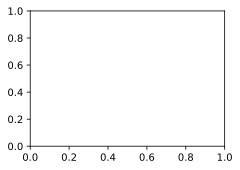

In [9]:
##################################################### 训练####################################################################################################################################################
####################################################################################################################################
timer = d2l.Timer()             #####计时打开
lr, num_epochs = 0.7,30         ####设置学习率以及 周期
train(net, mnist_train_iter, mnist_test_iter, num_epochs, lr, d2l.try_gpu())
# train(net, fashion_mnist_train_iter, fashion_mnist_test_iter, num_epochs, lr, d2l.try_gpu())
timer.stop()    ###输出响应时间

结果
Gpu
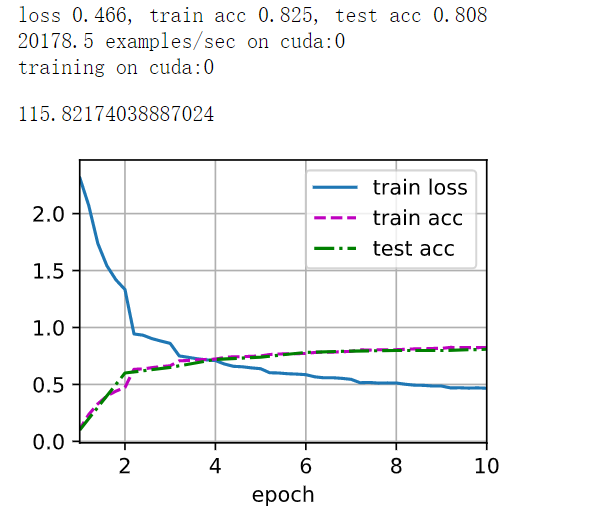                              
cpu
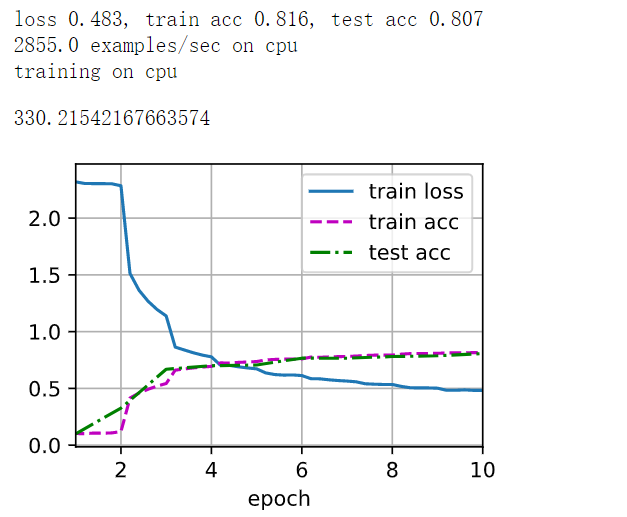
增加周期 降低学习率 30 0.7
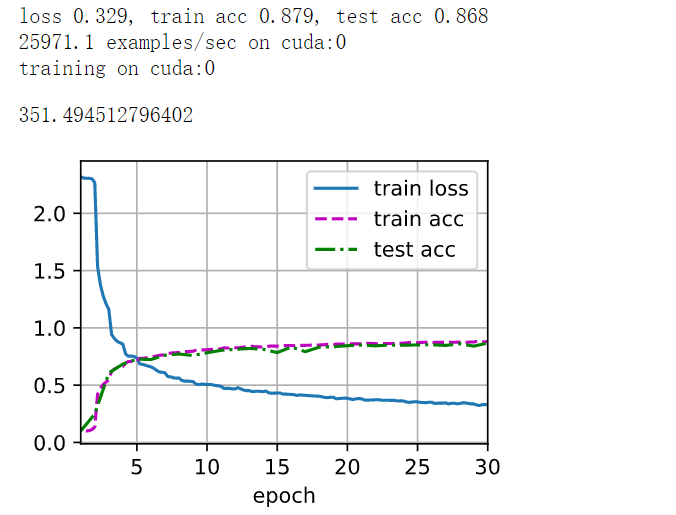
mnist数据集
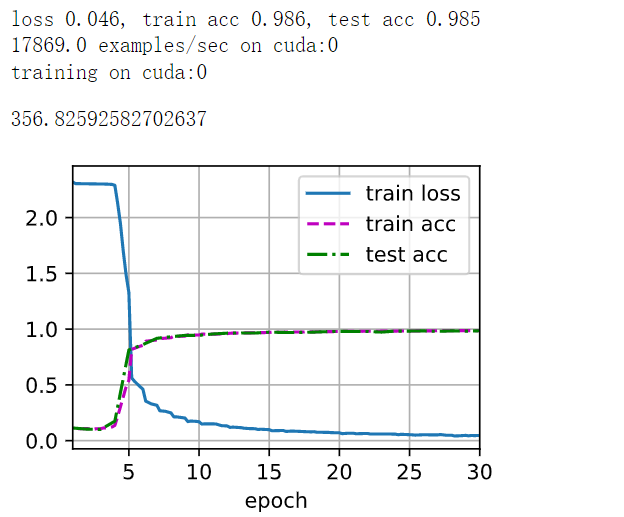

loss 0.022, train acc 0.994, test acc 0.986
31484.1 examples/sec on cuda:0
training on cuda:0


192.06751322746277

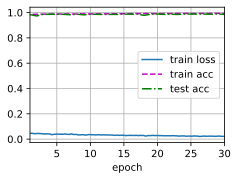

In [11]:
####################################保存模型 并且 使用用已有模型进行训练####################################################################################################################################################
####################################################################################################################################
torch.save(net.state_dict(),'mnist.params')
net.load_state_dict(torch.load('mnist.params'))
print('网络参数保存成功')
####################################测试保存的模型#################################################################################################################################
####################################################################################################################################
timer = d2l.Timer()             #####计时打开
lr, num_epochs = 0.7,30         ####设置学习率以及 周期
train(net, mnist_train_iter, mnist_test_iter, num_epochs, lr, d2l.try_gpu())
# train(net, fashion_mnist_train_iter, fashion_mnist_test_iter, num_epochs, lr, d2l.try_gpu())
timer.stop()    ###输出响应时间

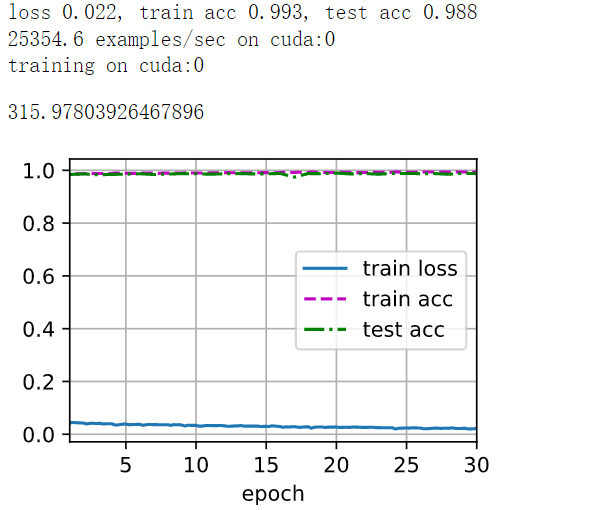

In [14]:
###################################################用mnist 数据集验证#########################################################################3333
trans = [transforms.ToTensor()]
trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)


input = mnist_train[1122][0].to(device) ####送进去gpu
output = net(Variable(input))
prob = F.softmax(output, dim=1)
prob = Variable(prob)
prob = prob.cpu().numpy()  #用GPU的数据训练的模型保存的参数都是gpu形式的，要显示则先要转回cpu，再转回numpy模式
print(prob)             #prob是10个分类的概率
pred = np.argmax(prob) #选出概率最大的一个
####打印预测标签
print('预测出来的数字：',pred.item())

####查看正确标签
print('正确的数字：',mnist_train[1122][1])

[[4.73080526e-08 5.76315813e-07 2.73686140e-09 1.10784255e-04
  1.45230105e-03 1.52046568e-05 4.24120605e-09 2.68180247e-05
  1.28430383e-06 9.98392880e-01]]
预测出来的数字： 9
正确的数字： 9


In [17]:
################################################自己手写验证 处理图像########################################################################
####################################################################################################################################
####定义形状改变函数
def ResizeImage(filein, fileout, width, height, type):
  img = Image.open(filein)
  out = img.resize((width, height),Image.ANTIALIAS)
  #resize image with high-quality
  out.save(fileout, type)
    

###二值化 颜色反转
img = cv2.imread('5.jpg')  #读取要预测的图片
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#图片转为灰度图，因为mnist数据集都是灰度图
ret, dst = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
cv2.imwrite('test_binary.png',255-dst)

img2 = cv2.imread('test_binary.png')


x_list =[]
y_list=[]
for i in range(0,img2.shape[0]):
    for j in range(0,img2.shape[1]):
        if img2[i,j,:][0] != 0:
            x_list.append(i)
            y_list.append(j)
    

######选出含有数字的区域
x_min =min(x_list)
x_max = max(x_list)
y_min =min(y_list)
y_max = max(y_list)

x_d = int((x_max-x_min)/5)
y_d = int((y_max-y_min)/5)


cv2.imwrite('test_binary.png',img2[x_min-x_d:x_max+x_d, y_min-y_d:y_max+y_d])
###变成需要的形状
filein ='test_binary.png'
fileout = 'test_resize.png'
width = 28
height = 28
ResizeImage(filein, fileout, width, height, 'PNG')



img = cv2.imread('test_resize.png')
transf = transforms.ToTensor()
my_mnist = transf(img)  ###转换成tensor类型
my_mnist,mnist_train[1111][0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.000

In [18]:
input = torch.Tensor(my_mnist).to(device) ####送进去gpu
output = net(Variable(input))
prob = F.softmax(output, dim=1)
prob = Variable(prob)
prob = prob.cpu().numpy()  #用GPU的数据训练的模型保存的参数都是gpu形式的，要显示则先要转回cpu，再转回numpy模式
# print(prob[0])                #prob是10个分类的概率
pred = np.argmax(prob[0]) #选出概率最大的一个
print('预测结果',pred.item())

预测结果 5
